In [1]:
from pathlib import Path
import pandas as pd
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [2]:
daic_gaze_train = load_original_daic("original_daic/train", "gaze")
daic_gaze_dev = load_original_daic("original_daic/dev", "gaze")
daic_gaze_test = load_original_daic("original_daic/test", "gaze")

In [3]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])


In [4]:
gaze_train = []
gaze_dev = []
gaze_test = []
for subject_id, subject_df in daic_gaze_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    gaze_train.append(temp)
for subject_id, subject_df in daic_gaze_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    gaze_dev.append(temp)
for subject_id, subject_df in daic_gaze_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    gaze_test.append(temp)

In [5]:
all_samples = gaze_train + gaze_dev + gaze_test
# all_samples = np.array(gaze_train + gaze_dev + gaze_test, dtype=object)
all_samples = np.concatenate((all_samples),)
# all_samples.shape
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

In [6]:
gaze_train = np.array(gaze_train)
gaze_dev = np.array(gaze_dev)
gaze_test = np.array(gaze_test)

In [7]:
norm_gaze_train = (gaze_train - min_values)/ptp_ranges
norm_gaze_dev = (gaze_dev - min_values)/ptp_ranges
norm_gaze_test = (gaze_test - min_values)/ptp_ranges

In [8]:
input_gaze = Input(shape=[5000, 12])
tdcn_dim_gaze = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_gaze = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [9]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [10]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    bn = BatchNormalization()(res_add)
    return bn
    # return residual

In [11]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for gaze
tdcn_gaze = time_diluted_conv_net(
    feature_dim = tdcn_dim_gaze, 
    input_layer = input_gaze, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_gaze])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_gaze)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_gaze, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
FC_l1 = Dense(16, activation="relu")(flatten)
FC_l2 = Dense(12, activation="relu")(FC_l1)
FC_l3 = Dense(8, activation="relu")(FC_l2)
last_layer = Dense(2, activation="sigmoid")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [12]:
model_gaze = Model(inputs=[input_gaze], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
# model_gaze.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
model_gaze.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [13]:
# model_gaze.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=2)
model_gaze.fit(gaze_train[:], y_train[:], validation_data=(gaze_dev[:], y_dev[:]), epochs=5)

Epoch 1/5
4/4 [==============================] - 21s 5s/step - loss: 0.6926 - accuracy: 0.5234 - val_loss: 0.6971 - val_accuracy: 0.5429
Epoch 2/5
4/4 [==============================] - 19s 5s/step - loss: 0.6931 - accuracy: 0.5234 - val_loss: 0.6937 - val_accuracy: 0.5429
Epoch 3/5
4/4 [==============================] - 20s 5s/step - loss: 0.6925 - accuracy: 0.5047 - val_loss: 0.6922 - val_accuracy: 0.6571
Epoch 4/5
4/4 [==============================] - 20s 5s/step - loss: 0.6916 - accuracy: 0.5140 - val_loss: 0.6916 - val_accuracy: 0.6571
Epoch 5/5
4/4 [==============================] - 20s 5s/step - loss: 0.6917 - accuracy: 0.5421 - val_loss: 0.6918 - val_accuracy: 0.6286


In [14]:
# model_gaze.evaluate(x=gaze_test, y=y_test)
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.2803738317757009
0.34285714285714286
0.2978723404255319


2/2 [==============================] - 2s 710ms/step
[1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0]
[[0.76923077 0.61904762]
 [0.23076923 0.38095238]]


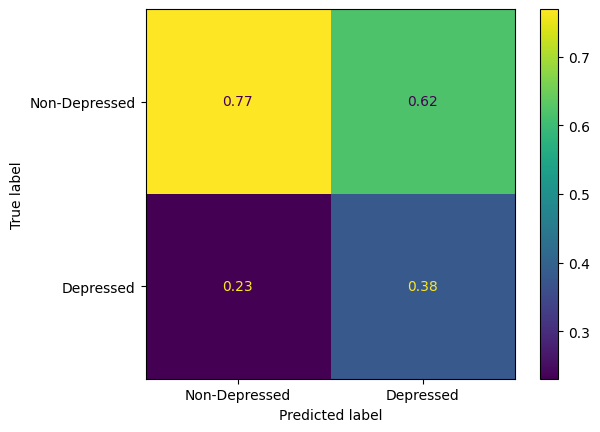

Accuracy = 0.575091575091575
Recall = 0.622754491017964
Precision = 0.38095238095238093
F1-score = 0.47272727272727266


In [15]:
#Predict
x = gaze_test
y = y_test
# x = x_dev_bad
# y = y_dev_bad
y_gaze_prediction = model_gaze.predict(x)
y_gaze_prediction = np.argmax(y_gaze_prediction, axis = 1)
# print(sum(y_gaze_prediction)/len(y_gaze_prediction))
print(y_gaze_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_gaze_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_gaze = result[0][0]
tp_gaze = result[1][1]
fn_gaze = result[1][0]
fp_gaze = result[0][1]
accuracy = (tp_gaze + tn_gaze)/(tp_gaze + tn_gaze + fp_gaze + fn_gaze)
recall = tp_gaze / (tp_gaze + fn_gaze)
precision = tp_gaze / (tp_gaze + fp_gaze)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [16]:
plot_model(model_gaze, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
# model_gaze.save("saved_models/good_gaze_21_6")